In [1]:
# demo de-noising using fhmm
# this is attempt 2,
# use HDP pickles and a new HDP during decoding

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
# useful functions

import noisey
import matplotlib.pyplot as plt
import importlib
importlib.reload(noisey)

signal_avg_db = -16 # from inspection

def get_noise_for_sample(signal_sample, sig_db=-16, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noisey_sample, _ = noisey.generate_gaussian_noise(len(signal_sample), noise_power_1, noise_power_2, noise_power_3)
    return noisey_sample


In [171]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK = 'humpback'
BOWHEAD = 'bowhead'
NOISE = 'noise'
HUMPBACK_B = 'humpback_b'
HUMPBACK_C = 'humpback_c'

# constants for fe and what not
fs = 4000
nfft = 256

signal_types = [HUMPBACK, NOISE, HUMPBACK_B, HUMPBACK_C] # BOWHEAD

# type to label
signal_types_labels = {
    HUMPBACK: 0,
    # BOWHEAD: 1,
    NOISE: 1,
    HUMPBACK_B: 2,
    HUMPBACK_C: 3
}

# label to type
label_to_type = {
    0: HUMPBACK,
    # 1: BOWHEAD,
    1: NOISE,
    2: HUMPBACK_B,
    3: HUMPBACK_C
}

get_data_dict = {
    HUMPBACK: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio)],
    HUMPBACK_B: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HIGH_CALLS_LABELS_A, fs, useful.file_to_audio)],
    HUMPBACK_C: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_MOOS, fs, useful.file_to_audio)],
    # BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_WHALE, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE_TIGHT, fs, useful.file_to_audio)],
            # get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_NOISE, fs, useful.file_to_audio)],
            # get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_NOISE, fs, useful.file_to_audio)]
}
samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)

__collected samples__
humpback :  18
noise :  38
humpback_b :  11
humpback_c :  18


In [156]:
# imports
from final.models.fhmm import FactorialHMM
from hmmlearn.hmm import GaussianHMM
import pickle
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)
import sklearn.metrics
import decode_combine as dc
importlib.reload(dc)

<module 'decode_combine' from '/Users/david/Documents/mastersCode/ubm/final/tests/decode_combine.py'>

In [157]:
from spafe.features import mfcc, lfcc, bfcc

def get_mfcc_feature(sample, fs, nfft):
    return librosa.feature.mfcc(y=sample,sr=fs,n_mfcc=13, n_fft=nfft)

def get_mfcc_delta(sample, fs, nfft):
    feat = mfcc.mfcc(sample, fs=fs, nfft=nfft)
    delta = librosa.feature.delta(feat)
    return np.hstack((feat, delta))

from spafe.features import mfcc, lfcc, bfcc

def get_lfcc_feature(sample, fs, nfft):
    return lfcc.lfcc(sample, fs=fs, nfft=nfft)

def get_feature(samp):
    # add optionals here if needed
    # mfcc
    # feat = get_lfcc_feature(samp, 4000, 128)
    feat = useful.get_log_power_feature(samp, nfft=128)
    return feat[:,2:]

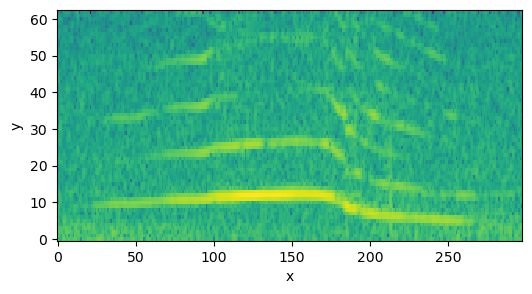

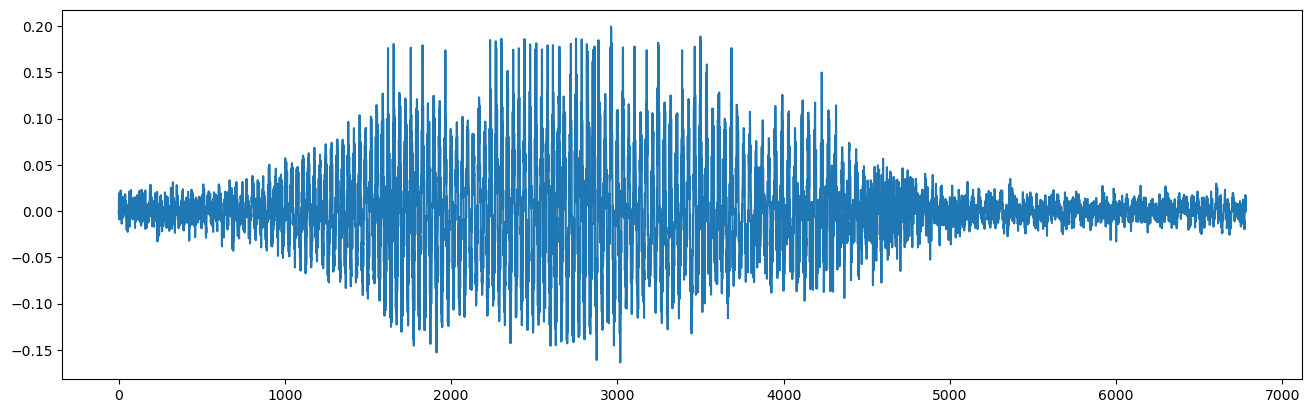

In [158]:
useful.vis_helper(get_feature(samples[5]))
plt.plot(samples[-5])

In [172]:
# separate using cross-validation
n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.05)

# snrs = [30,20,18,15,10,5]
# base_snr = 30

In [173]:
cv_index = 1

train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])

# train
hmms = {
HUMPBACK: GaussianHMM(8),
HUMPBACK_B: GaussianHMM(8),
HUMPBACK_C: GaussianHMM(8),
NOISE: GaussianHMM(5),
# HUMPBACK_C: GaussianHMM(5)
}

train.features = []
for i in range(len(train.samples)):
    noise_sample = get_noise_for_sample(train.samples[i], signal_avg_db, 50, 40, 40)
    adjusted_sample = train.samples[i] # + noise_sample
    train.features.append(get_feature(adjusted_sample))

for key in hmms:
    cur_hmm = hmms[key]
    feat_indicis = train.sample_labels == signal_types_labels[key]
    hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
    cur_hmm.fit(np.concatenate(hmm_features))

In [174]:
useful.find_similar_states_kl(hmms[HUMPBACK], hmms[NOISE], 10**2)

array([[111.3847507 , 133.30561898,  99.72941023, 115.03667755,
        111.92110742],
       [ 59.99739206,  64.66169697,  66.6273302 ,  64.79164968,
         59.69203985],
       [110.33582719, 131.7168515 , 120.9696976 , 140.94328036,
        130.52783823],
       [142.64570994, 179.46752811, 170.21785677, 159.29031582,
        149.05628804],
       [ 12.8370044 ,  15.18835919,  12.89365034,  14.93799332,
         12.49980972],
       [161.52937765, 179.18797976, 181.03544682, 169.78162329,
        168.32792084],
       [175.99283507, 163.8166076 , 139.05210674, 153.90282848,
        158.33322736],
       [133.82569287, 116.04332503, 112.64753054, 129.83400198,
        119.63553353]])

In [143]:
hmms[HUMPBACK] = useful.delete_component(hmms[HUMPBACK], 3)
# useful.vis_helper(np.concatenate(train.features)[0:2000])

deleting comp 3


In [132]:
hmms_test = useful.delete_component(hmms[HUMPBACK], 3)

deleting comp 3


In [175]:
# adjustment for sliding windows and noise introduction
importlib.reload(useful)

val_noise_indices = val.sample_labels == signal_types_labels['noise']
val_noise_samples = [item for item, condition in zip(val.samples, val_noise_indices) if condition]

# adjust samples so that there are more noise samples, and in the middle there is a long break
new_val_labels = []
new_val_samples = []

for i in range(len(val.samples)):
    if int(val.sample_labels[i]) is not signal_types_labels['noise']:
        new_val_samples.append(val_noise_samples[np.random.randint(0,len(val_noise_samples))])
        new_val_labels.append(signal_types_labels['noise'])
        new_val_samples.append(val.samples[i])
        new_val_labels.append(val.sample_labels[i])
    else:
        new_val_samples.append(val.samples[i])
        new_val_labels.append(val.sample_labels[i])

val_new = useful.SampleHolder(new_val_samples, [int(num) for num in new_val_labels])

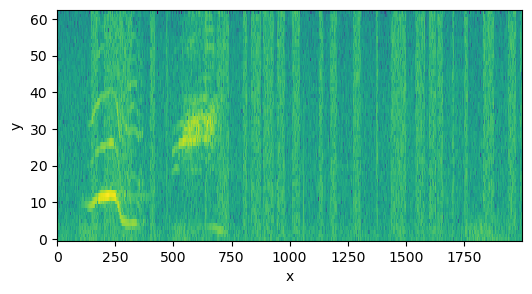

In [176]:

val_new.features = []
true_noise_features = []
true_noise_samples = []
combined_noise_features = []
for i in range(len(val_new.samples)):
    # ---- noise / reverb adjustments ---- START
    noise_sample = get_noise_for_sample(val_new.samples[i], signal_avg_db, 15, 40, 40)
    true_noise_features.append(get_feature(noise_sample))
    true_noise_samples.append(noise_sample)
    adjusted_sample = val_new.samples[i] + noise_sample
    # ---- noise / reverb adjustments ---- END

    feature = get_feature(adjusted_sample)
    if val_new.sample_labels[i] == signal_types_labels['noise']:
        combined_noise_features.append(feature)
    val_new.features.append(feature)
val_new.update_feature_labels()

useful.vis_helper(np.concatenate(val_new.features)[:2000])

combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])
_, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val_new.features))


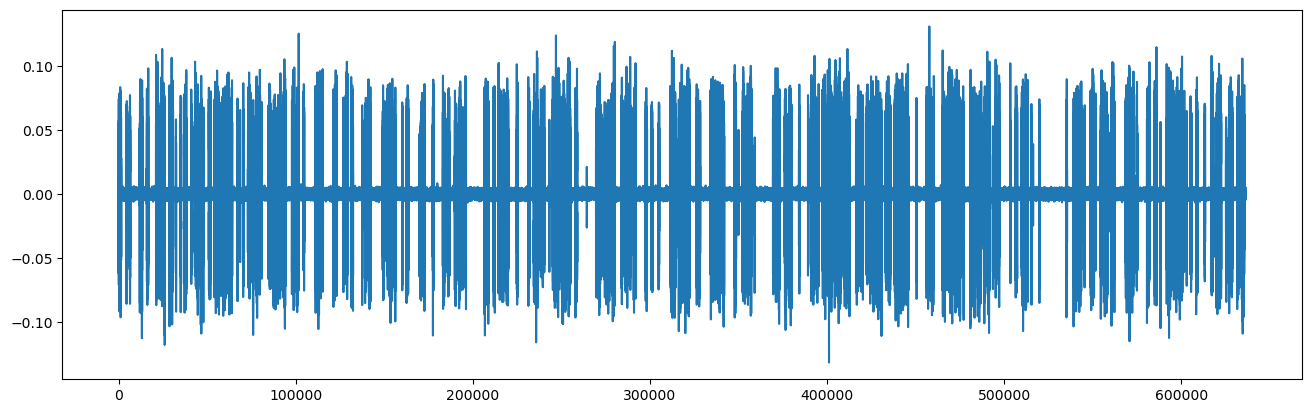

In [96]:
plt.plot(np.concatenate(true_noise_samples))

In [177]:
accuracy = useful.perf_measure_multi(np.concatenate(val_new.feature_labels), val_pred, True)
print('base accuracy: ', accuracy)


base accuracy:  {'ACC': 0.7580962440839905, 'PPV': 0.2527292149874255, 'TPR': 0.29157016397898805, 'TNR': 0.8826143147454159, 'FPR': 0.11738568525458411, 'FNR': 0.708429836021012}


In [170]:
set(np.array(np.concatenate(val_new.feature_labels)))

{0.0, 2.0, 3.0, 4.0}

In [178]:
# true
noise_hmm_v1 = GaussianHMM(2, covariance_type='diag', init_params='')
noise_hmm_v1.fit(np.concatenate(true_noise_features))

# noise_hmm_v2 = GaussianHMM(5, covariance_type='diag', init_params='')
# noise_hmm_v2.fit(np.concatenate(combined_noise_features))

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm_v1)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, _ = combined_model_fhmm.decode_hmmlearn(np.concatenate(val_new.features))
accuracy = useful.perf_measure_multi(np.concatenate(val_new.feature_labels), val_pred_fhmm, True)
print('true: ', accuracy)

true:  {'ACC': 0.8229687517698707, 'PPV': 0.40669819986202005, 'TPR': 0.34888540223131037, 'TNR': 0.9028392083142988, 'FPR': 0.09716079168570124, 'FNR': 0.6511145977686896}


In [128]:
useful.find_similar_states_kl(hmms[HUMPBACK], hmms[NOISE], 10**2)

array([[ 59.16569527, 108.71203097, 127.671716  ,  59.11302277,
         53.61760024],
       [ 42.26064593, 136.12994842, 157.93011085,  37.33577475,
         37.73784769],
       [ 66.17616779, 125.8411941 , 154.44540402,  73.84387524,
         74.25977117],
       [ 37.7910761 ,  12.95934733,  13.09939813,  36.93406335,
         49.93811098],
       [ 31.04701515,  61.7895565 ,  72.18199157,  27.70472785,
         38.46044032]])

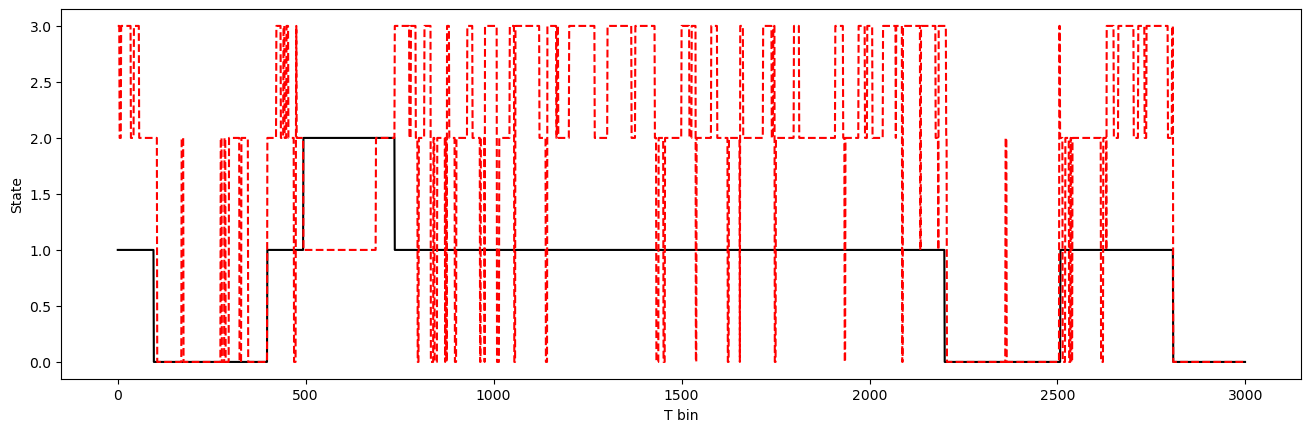

<module 'final.useful' from '/Users/david/Documents/mastersCode/ubm/final/useful.py'>

In [179]:

subset_start = 0 # 4500 #
subset_end = 3000 # 6500   #

val_true_subset = np.concatenate(val_new.feature_labels)[subset_start:subset_end]
val_pred_subset = val_pred[subset_start:subset_end]
val_features_subset = np.concatenate(val_new.features)[subset_start:subset_end]

import matplotlib.pyplot as plt
plt.plot(val_true_subset, c='black')
plt.plot(val_pred_subset, '--', c='red')
plt.xlabel('T bin')
plt.ylabel('State')
plt.show()

importlib.reload(useful)

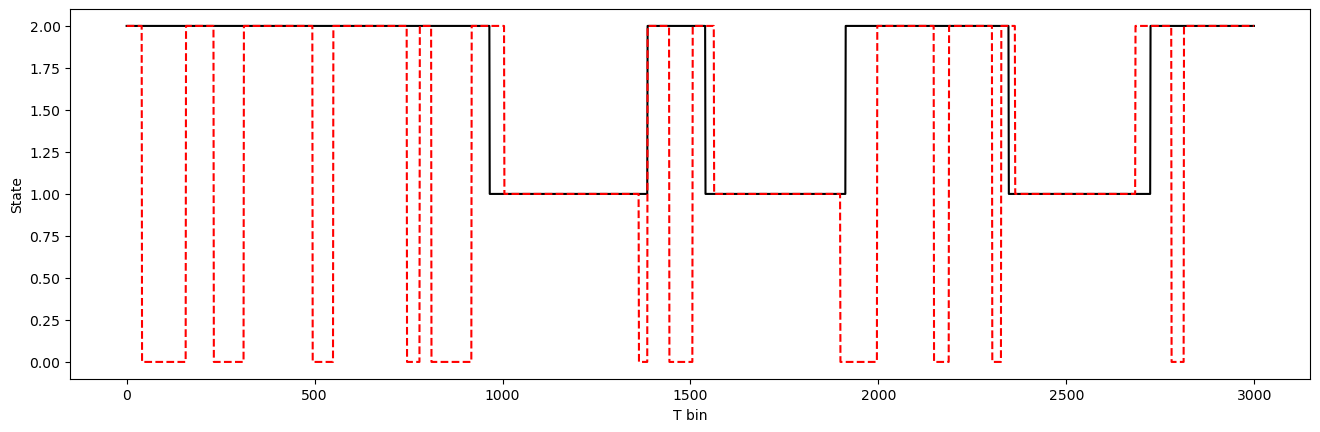

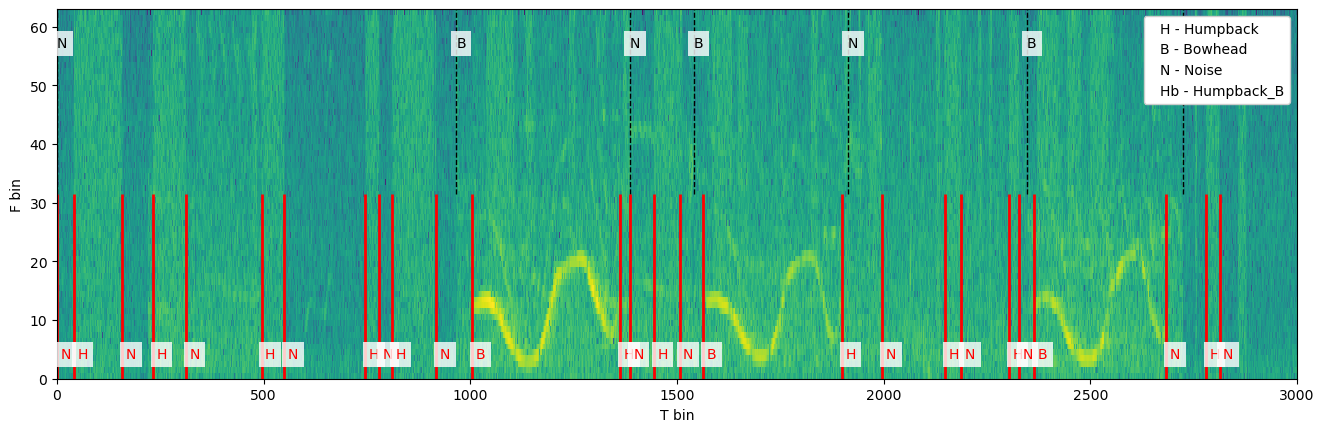

In [150]:

val_pred_subset_smoothed = useful.smooth_labels(val_pred_subset)
plt.plot(val_true_subset,c='black')
plt.plot(val_pred_subset_smoothed, '--', c='red')
plt.xlabel('T bin')
plt.ylabel('State')
plt.show()

importlib.reload(useful)

label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N',
    3: 'Hb',
    # 4: 'Hc'
}

useful.plot_spectrogram(val_features_subset, val_true_subset, useful.smooth_labels(val_pred_subset_smoothed), label_to_type, label_to_abr)


In [ ]:
# Log - power
# base accuracy 30 - 30
# base accuracy:  {'ACC': 0.9915883460678728, 'PPV': 0.960320696353581, 'TPR': 0.9342088140763151, 'TNR': 0.995018838374928, 'FPR': 0.00498116162507195, 'FNR': 0.06579118592368492}
# 20 - 20
# base accuracy:  {'ACC': 0.9822581728578186, 'PPV': 0.8834872615622114, 'TPR': 0.8846655620679371, 'TNR': 0.9898298309539924, 'FPR': 0.010170169046007708, 'FNR': 0.11533443793206292}
# 15 - 17
# base accuracy:  {'ACC': 0.9630449292433421, 'PPV': 0.8084633488667737, 'TPR': 0.7954809555219389, 'TNR': 0.9807208032686028, 'FPR': 0.01927919673139715, 'FNR': 0.20451904447806127}

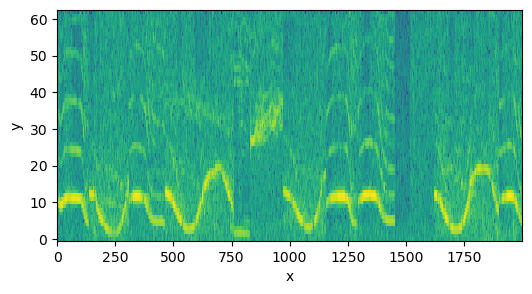

In [340]:
# plt.plot(np.concatenate(true_noise_samples))
# useful.vis_helper(np.concatenate(val.features)[0:2000])

In [196]:
# useful.vis_helper(np.concatenate(val.features)[:1000])

In [193]:
# 10 * np.log10(utils.get_average_power(np.concatenate(true_noise_samples), use_buffer=True))

-37.38395226472729

In [409]:
# train update noise hmms
importlib.reload(useful)

noise_hmm_v1 = GaussianHMM(5, covariance_type='diag', init_params='')
noise_hmm_v1.fit(np.concatenate(true_noise_features))

# noise_hmm_v2 = GaussianHMM(5, covariance_type='diag', init_params='')
# noise_hmm_v2.fit(np.concatenate(combined_noise_features))
#
# noise_hmm_v3 = GaussianHMM(5, covariance_type='diag', init_params='')
# noise_hmm_v3.fit(np.concatenate(combined_noise_features))

# reverse fhmm process to find estimate noise hmm - update this to delete only inf...
# noise_hmm_v2.means_ = useful.reverse_fhmm(noise_hmm_v2, hmms[NOISE])
# noise_hmm_v3.means_ = useful.reverse_fhmm(noise_hmm_v3, hmms[NOISE])

true:  {'ACC': 0.9472097329262845, 'PPV': 0.7101944894881942, 'TPR': 0.7578426910945741, 'TNR': 0.9683346557313284, 'FPR': 0.031665344268671694, 'FNR': 0.24215730890542583}


In [411]:
# estimate
# fhmms = {}
# for key in hmms:
#     fhmm = FactorialHMM(hmms[key], noise_hmm_v2)
#     fhmms[key] = fhmm.hmm
#
# combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])
#
# _, val_pred_fhmm, _ = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))

In [33]:
# importlib.reload(useful)
# accuracy = useful.perf_measure_multi(np.concatenate(val.feature_labels), val_pred_fhmm, avg_only=True)
# print('est: ', accuracy)
#
# accuracy_all = useful.perf_measure_multi_all(np.concatenate(val.feature_labels), val_pred_fhmm)
# print('est: ', accuracy)

NameError: name 'val_pred_fhmm' is not defined

In [560]:
# test_pd = pd.DataFrame(accuracy_all).transpose()
# concatenated_df = pd.concat(test_pd.values(), axis=0, ignore_index=True)

In [526]:
# useful.vis_helper(np.concatenate(val.features)[:3000])

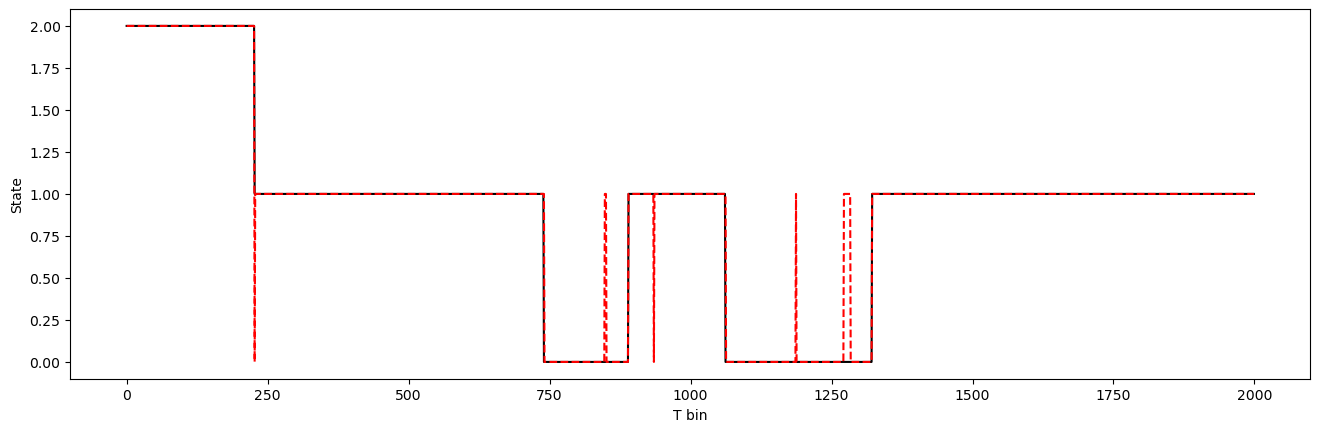

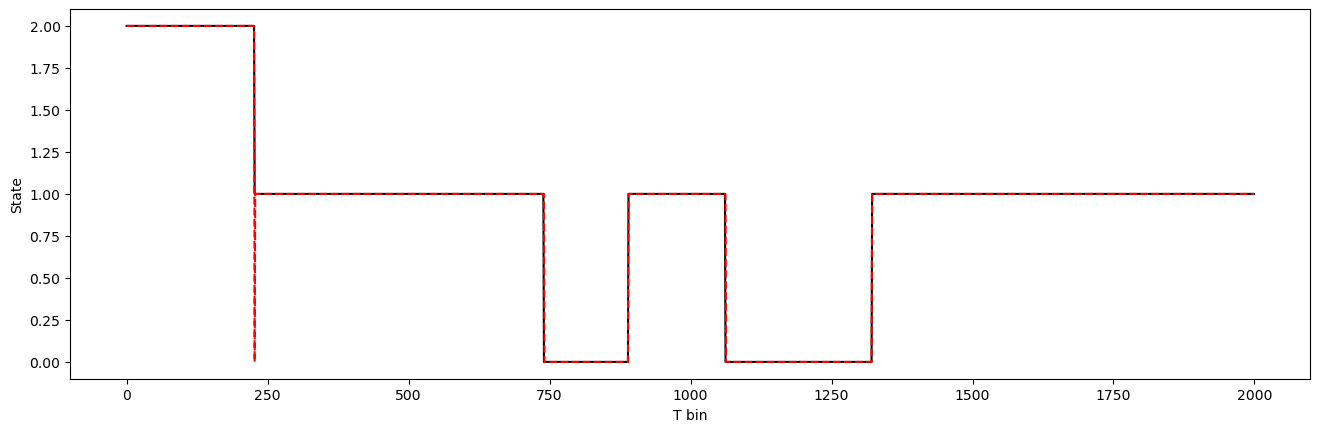

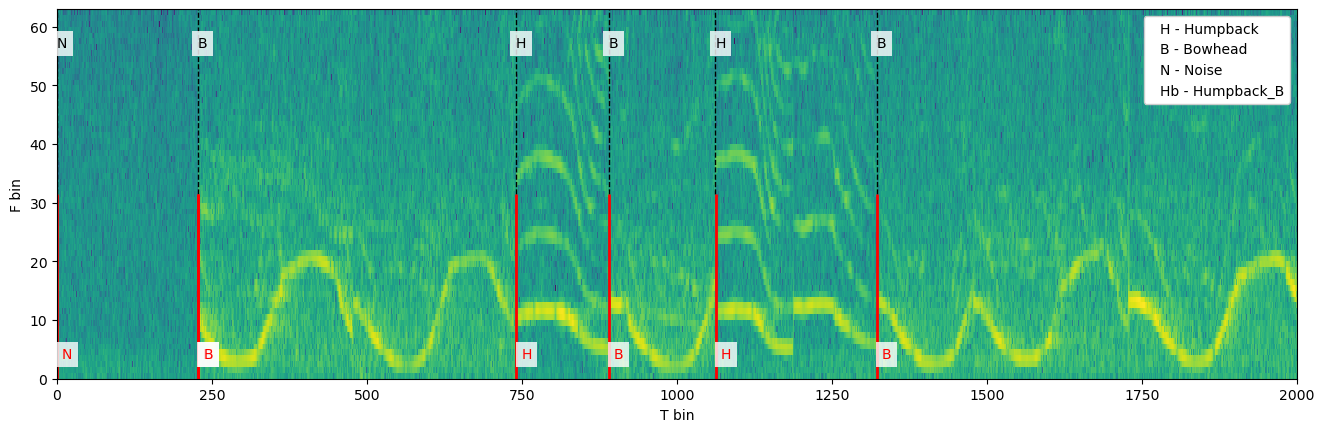

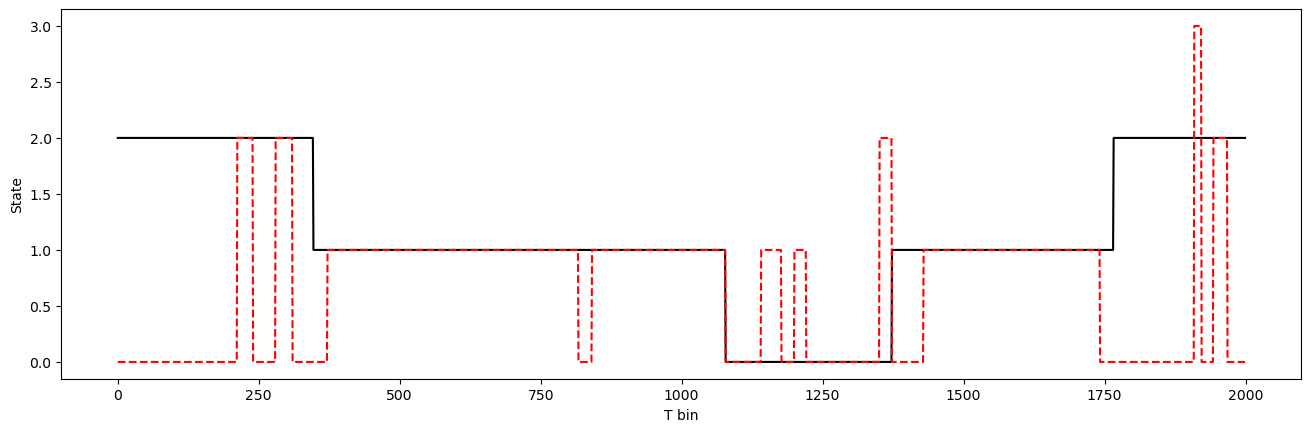

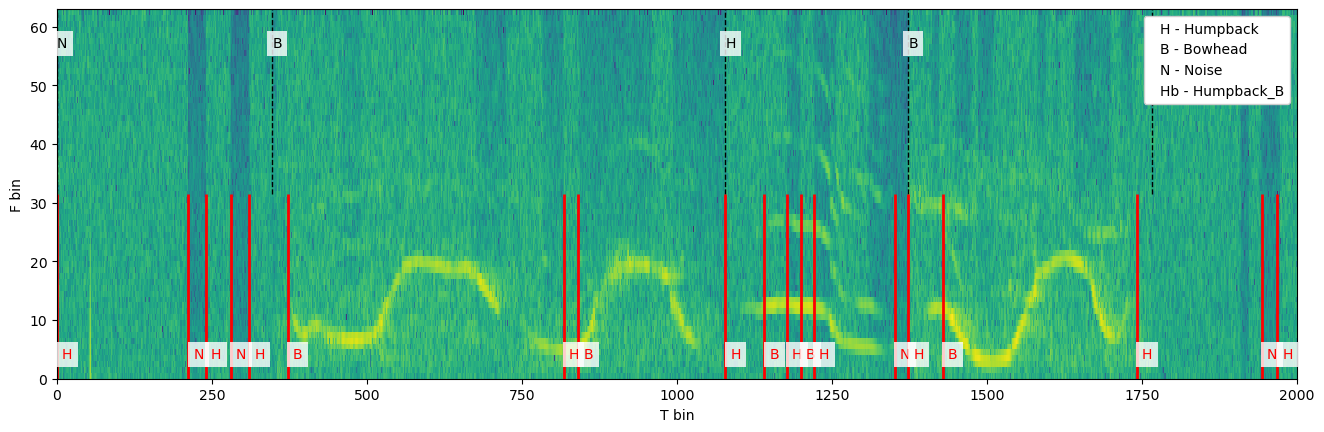

In [ ]:
import matplotlib.pyplot as plt

plt_data = {
    'True': {'SNR': [30, 25, 20, 19, 18, 17, 16, 15],
             'ACC': [0.93508, 0.91874, 0.92522, 0.91979, 0.91437, 0.91025, 0.91523, 0.91024]},

    'Est': {'SNR': [30, 25, 20, 19, 18, 17, 16, 15],
        'ACC': [0.93068, 0.89283, 0.90302, 0.89535, 0.9062, 0.89526, 0.89511, 0.8901]},

    'Input': {'SNR': [30, 25, 20, 19, 18, 17, 16, 15],
              'ACC': [0.86343, 0.85337, 0.85072, 0.83634, 0.83232, 0.82471, 0.81645, 0.8074]},

    'Base': {'SNR': [30, 25, 20, 19, 18, 17, 16, 15],
         'ACC': [0.922, 0.891, 0.833, 0.822, 0.785, 0.786, 0.764, 0.764]},

    'MFCC': {'SNR': [30, 25, 20, 19, 18, 17, 16, 15],
             'ACC': [0.86741, 0.84713, 0.81707, 0.77644, 0.77542, 0.79924, 0.80019, 0.74904]},

    'LFCC': {'SNR': [30, 25, 20, 19, 18, 17, 16, 15],
             'ACC': [0.83680, 0.82624, 0.84396, 0.84690, 0.83222, 0.85828, 0.87056, 0.84348]}
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

models = list(plt_data.keys())
colors = ['g', 'r', 'b', 'darkblue', 'lightgreen', 'lightblue']  # Use different colors for each model

x_axis = np.arange(len(np.array([30, 25, 20, 19, 18, 17, 16, 15]))) * 3

for i, model in enumerate(models):
    snr = plt_data[model]['SNR']
    acc = plt_data[model]['ACC']
    ax.plot(x_axis, acc, label=model, marker='o', color=colors[i], linestyle='-')
    # ax.bar([x + i * 0.3 for x in x_axis], acc, width=0.3, label=model, color=colors[i])

snr_labels = plt_data['Base']['SNR']
# Set custom x-axis labels
ax.set_xticks(x_axis)
ax.set_xticklabels(snr_labels)

ax.set_ylim(0.7, 1.0)
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Models')
ax.legend()

plt.show()


# Testing

In [130]:
# adjustment for sliding windows and noise introduction

importlib.reload(useful)

train_noise_indices = train.sample_labels == signal_types_labels['noise']
train_noise_samples = [item for item, condition in zip(train.samples, train_noise_indices) if condition]

# adjust samples so that there are more noise samples, and in the middle there is a long break
new_test_labels = []
new_test_samples = []

for i in range(len(test.samples)):
    new_test_samples.append(test.samples[i])
    new_test_labels.append(test.sample_labels[i])
    if int(test.sample_labels[i]) is not signal_types_labels['noise']:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
    if i == len(test.samples) // 2:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])

test_new = useful.SampleHolder(new_test_samples, [int(num) for num in new_test_labels])

In [139]:
test_new.features = []
test_noise_samples = []
test_noise_features = []

for i in range(len(test_new.samples)):
    if i < len(test_new.samples) // 2:
        # ---- noise / reverb adjustments ---- START
        noise_sample = get_noise_for_sample(signal_avg_db, test_new.samples[i], 35, 38, 40)
        test_noise_samples.append(noise_sample)
        test_noise_features.append(get_feature(noise_sample))
        adjusted_sample = test_new.samples[i] + noise_sample
        # ---- noise / reverb adjustments ---- END
        feature = get_feature(adjusted_sample)
    else:
        # ---- noise / reverb adjustments ---- START
        noise_sample = get_noise_for_sample(signal_avg_db, test_new.samples[i], 16, 16, 30)
        # test_noise_samples.append(noise_sample)
        # test_noise_features.append(get_feature(noise_sample))
        adjusted_sample = test_new.samples[i] + noise_sample
        # ---- noise / reverb adjustments ---- END
        feature = get_feature(adjusted_sample)
    test_new.features.append(feature)
test_new.update_feature_labels()

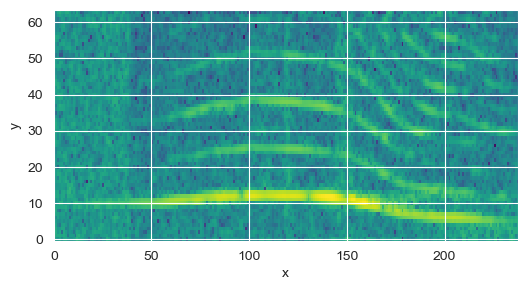

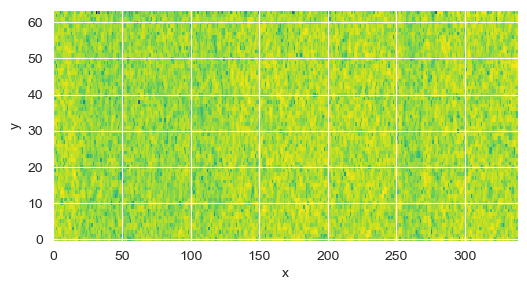

In [140]:
# useful.vis_helper(train.features[5])
useful.vis_helper(test_new.features[-3])
useful.vis_helper(test_noise_features[0])

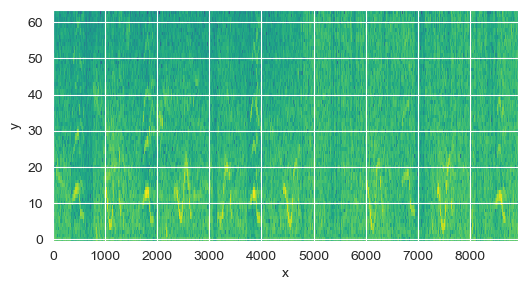

{'ACC': 0.5845384752722728, 'PPV': 0.5817792723937634, 'TPR': 0.6649196366177498, 'TNR': 0.5005476451259584, 'FPR': 0.4994523548740416, 'FNR': 0.33508036338225017}


In [87]:
test_features_concat = np.concatenate(test_new.features)
_, test_pred, test_log_prob = combined_model.decode_hmmlearn(test_features_concat)
useful.vis_helper(test_features_concat)
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels), test_pred)
print(accuracy)
## use fhmm_dc from above trained on noise as well

In [141]:
# train hdp-hmm
import final.models.hdphmm.hdphmmwl.consts as const
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmmwl
importlib.reload(hdphmmwl)

concatenated_list = [
    np.concatenate(random.sample(test_noise_features, 4))
    for _ in range(10)
]

sbp = {
    const.ALPHA0: 100,
    const.GAMMA0: 1000,
    const.KAPPA0: 50,
}
sbp[const.RHO0] = sbp[const.KAPPA0] / ( sbp[const.KAPPA0] + sbp[const.ALPHA0])

noise_ihmm = hdphmmwl.HDPHMMWL(concatenated_list, 20, sbp=sbp)

sbp given


In [128]:
test_noise_hmm = GaussianHMM(4)
test_noise_hmm.fit(np.concatenate(test_noise_features))

GaussianHMM(n_components=4)

iterations per sample:  1
Gibb sampling on sample index:  0 outer it:  0
it:  0  || Likelihood:  -21001.867405818615  || n_components:  20
Gibb sampling on sample index:  1 outer it:  0
it:  0  || Likelihood:  -21428.763628600864  || n_components:  20
Gibb sampling on sample index:  2 outer it:  0
it:  0  || Likelihood:  -21410.72873288313  || n_components:  20
Gibb sampling on sample index:  3 outer it:  0
it:  0  || Likelihood:  -21203.353425290992  || n_components:  18
Gibb sampling on sample index:  4 outer it:  0
it:  0  || Likelihood:  -21256.596485677517  || n_components:  18
Gibb sampling on sample index:  5 outer it:  0
it:  0  || Likelihood:  -21324.242469819656  || n_components:  13
Gibb sampling on sample index:  6 outer it:  0
it:  0  || Likelihood:  -21267.85555658941  || n_components:  12
Gibb sampling on sample index:  7 outer it:  0
it:  0  || Likelihood:  -21319.557258683708  || n_components:  10
Gibb sampling on sample index:  8 outer it:  0
it:  0  || Likelihood:  -

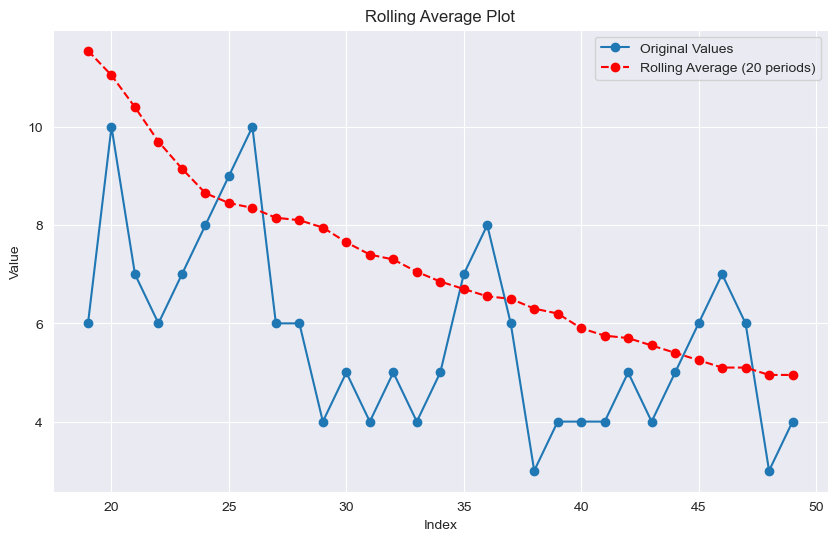

8.06
4.406404429917889
Gibb sampling on sample index:  0 outer it:  5
it:  0  || Likelihood:  -21267.480193264033  || n_components:  4
Gibb sampling on sample index:  1 outer it:  5
it:  0  || Likelihood:  -21602.67332427469  || n_components:  4
Gibb sampling on sample index:  2 outer it:  5
it:  0  || Likelihood:  -21518.809720928562  || n_components:  4
Gibb sampling on sample index:  3 outer it:  5
it:  0  || Likelihood:  -21309.98125511135  || n_components:  4
Gibb sampling on sample index:  4 outer it:  5
it:  0  || Likelihood:  -21408.160552320438  || n_components:  5
Gibb sampling on sample index:  5 outer it:  5
it:  0  || Likelihood:  -21344.22005919559  || n_components:  6
Gibb sampling on sample index:  6 outer it:  5
it:  0  || Likelihood:  -21230.62935352854  || n_components:  7
Gibb sampling on sample index:  7 outer it:  5
it:  0  || Likelihood:  -21367.064330929865  || n_components:  5
Gibb sampling on sample index:  8 outer it:  5
it:  0  || Likelihood:  -21579.1173230

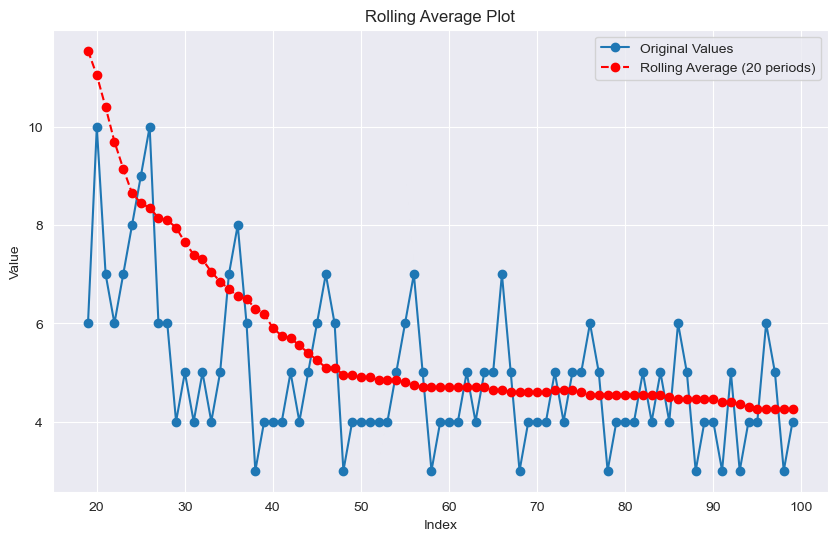

4.44
0.9624967532412771
Gibb sampling on sample index:  0 outer it:  10
it:  0  || Likelihood:  -21265.541191297616  || n_components:  3
Gibb sampling on sample index:  1 outer it:  10
it:  0  || Likelihood:  -21601.316172207597  || n_components:  3
Gibb sampling on sample index:  2 outer it:  10
it:  0  || Likelihood:  -21510.28746347158  || n_components:  5
Gibb sampling on sample index:  3 outer it:  10
it:  0  || Likelihood:  -21318.688820842417  || n_components:  3
Gibb sampling on sample index:  4 outer it:  10
it:  0  || Likelihood:  -21395.09475859248  || n_components:  4
Gibb sampling on sample index:  5 outer it:  10
it:  0  || Likelihood:  -21337.420594476946  || n_components:  4
Gibb sampling on sample index:  6 outer it:  10
it:  0  || Likelihood:  -21233.95242241076  || n_components:  6
Gibb sampling on sample index:  7 outer it:  10
it:  0  || Likelihood:  -21303.34223021095  || n_components:  5
Gibb sampling on sample index:  8 outer it:  10
it:  0  || Likelihood:  -215

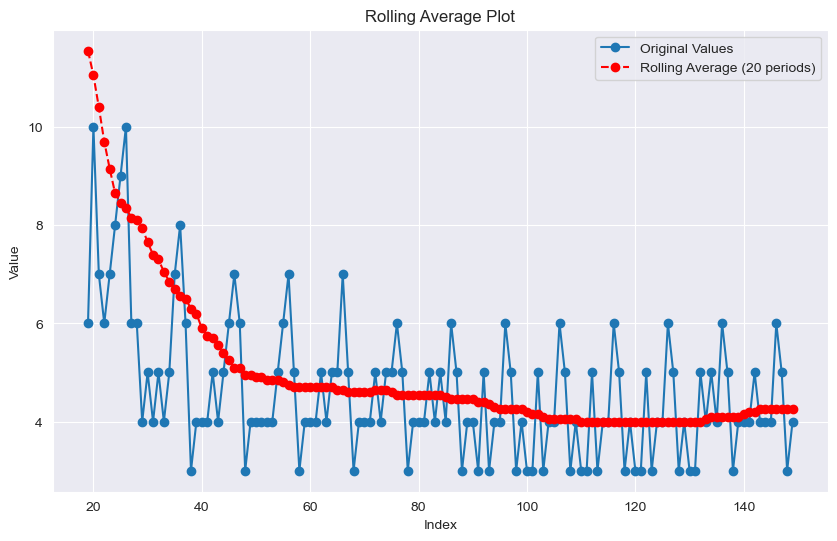

4.1
0.9643650760992956
its:  150
4.27
0.9783148777362022
Gibb sampling on sample index:  0 outer it:  15
it:  0  || Likelihood:  -21226.031346470263  || n_components:  4
Gibb sampling on sample index:  1 outer it:  15
it:  0  || Likelihood:  -21585.10291805578  || n_components:  4
Gibb sampling on sample index:  2 outer it:  15
it:  0  || Likelihood:  -21517.470942077165  || n_components:  4
Gibb sampling on sample index:  3 outer it:  15
it:  0  || Likelihood:  -21306.882933157896  || n_components:  4
Gibb sampling on sample index:  4 outer it:  15
it:  0  || Likelihood:  -21424.22575583122  || n_components:  5
Gibb sampling on sample index:  5 outer it:  15
it:  0  || Likelihood:  -21344.761328810466  || n_components:  4
Gibb sampling on sample index:  6 outer it:  15
it:  0  || Likelihood:  -21235.747402674504  || n_components:  5
Gibb sampling on sample index:  7 outer it:  15
it:  0  || Likelihood:  -21304.600194834085  || n_components:  4
Gibb sampling on sample index:  8 outer i

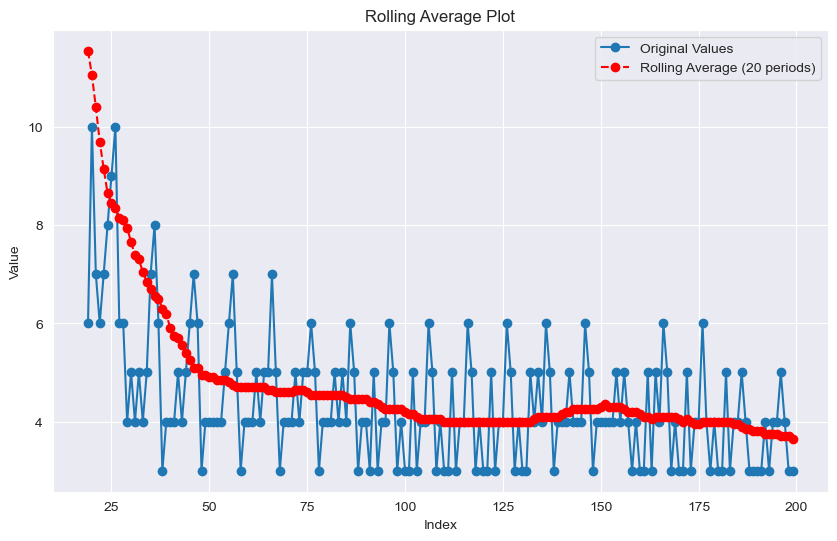

3.88
0.84
its:  200
3.99
0.9109884741312594
Gibb sampling on sample index:  0 outer it:  20
it:  0  || Likelihood:  -21254.411209672195  || n_components:  3
Gibb sampling on sample index:  1 outer it:  20
it:  0  || Likelihood:  -21581.66648606869  || n_components:  3
Gibb sampling on sample index:  2 outer it:  20
it:  0  || Likelihood:  -21536.13210994211  || n_components:  4
Gibb sampling on sample index:  3 outer it:  20
it:  0  || Likelihood:  -21291.35881213166  || n_components:  3
Gibb sampling on sample index:  4 outer it:  20
it:  0  || Likelihood:  -21439.586618576515  || n_components:  4
Gibb sampling on sample index:  5 outer it:  20
it:  0  || Likelihood:  -21362.9864513085  || n_components:  4
Gibb sampling on sample index:  6 outer it:  20
it:  0  || Likelihood:  -21229.201947758138  || n_components:  4
Gibb sampling on sample index:  7 outer it:  20
it:  0  || Likelihood:  -21298.161771575877  || n_components:  4
Gibb sampling on sample index:  8 outer it:  20
it:  0  |

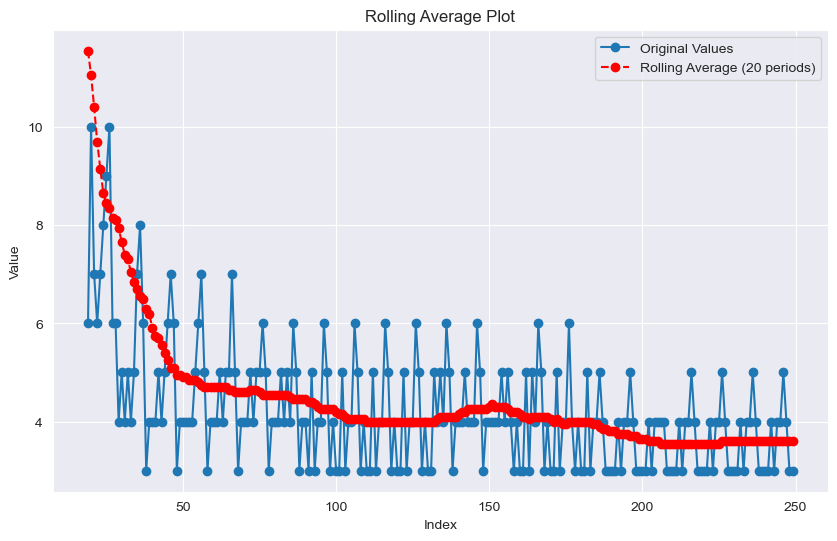

3.58
0.6352952069707437
its:  250
3.73
0.759670981412348
Gibb sampling on sample index:  0 outer it:  25
it:  0  || Likelihood:  -21276.935203664485  || n_components:  3
Gibb sampling on sample index:  1 outer it:  25
it:  0  || Likelihood:  -21580.141806538086  || n_components:  3
Gibb sampling on sample index:  2 outer it:  25
it:  0  || Likelihood:  -21502.95588445592  || n_components:  4
Gibb sampling on sample index:  3 outer it:  25
it:  0  || Likelihood:  -21282.288968901325  || n_components:  3
Gibb sampling on sample index:  4 outer it:  25
it:  0  || Likelihood:  -21378.298598938323  || n_components:  4
Gibb sampling on sample index:  5 outer it:  25
it:  0  || Likelihood:  -21368.019854951843  || n_components:  4
Gibb sampling on sample index:  6 outer it:  25
it:  0  || Likelihood:  -21234.2298365162  || n_components:  5
Gibb sampling on sample index:  7 outer it:  25
it:  0  || Likelihood:  -21321.84868458192  || n_components:  4
Gibb sampling on sample index:  8 outer it:

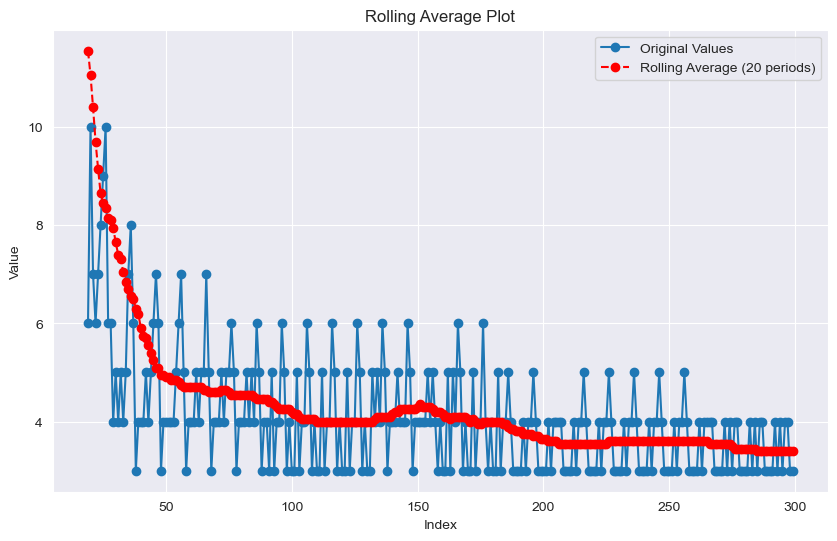

3.46
0.5370288632839021
its:  300
3.52
0.5912698199637795
Gibb sampling on sample index:  0 outer it:  30
it:  0  || Likelihood:  -21248.164419197743  || n_components:  3
Gibb sampling on sample index:  1 outer it:  30
it:  0  || Likelihood:  -21586.517801707538  || n_components:  3
Gibb sampling on sample index:  2 outer it:  30
it:  0  || Likelihood:  -21512.34178347493  || n_components:  4
Gibb sampling on sample index:  3 outer it:  30
it:  0  || Likelihood:  -21312.91774695828  || n_components:  3
Gibb sampling on sample index:  4 outer it:  30
it:  0  || Likelihood:  -21407.749693532605  || n_components:  4
Gibb sampling on sample index:  5 outer it:  30
it:  0  || Likelihood:  -21342.832364386242  || n_components:  3
Gibb sampling on sample index:  6 outer it:  30
it:  0  || Likelihood:  -21234.24759384473  || n_components:  4
Gibb sampling on sample index:  7 outer it:  30
it:  0  || Likelihood:  -21302.05692271953  || n_components:  4
Gibb sampling on sample index:  8 outer it

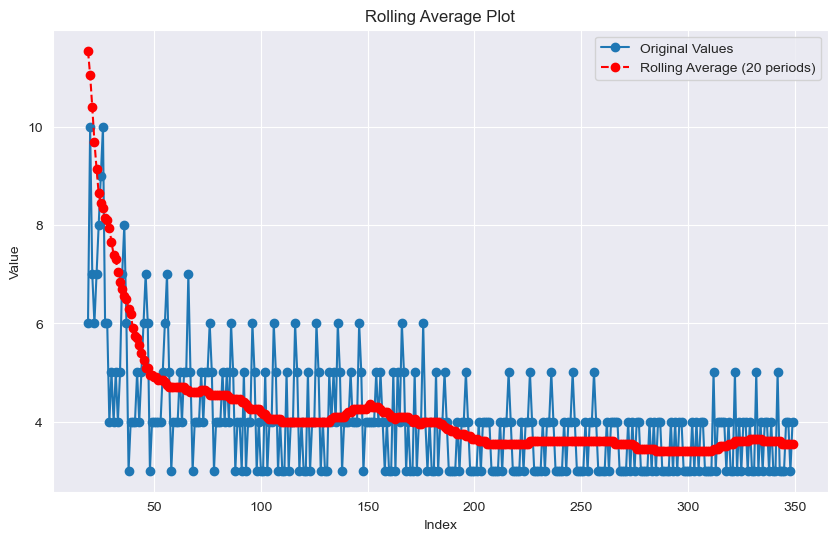

3.56
0.6374950980203692
its:  350
3.51
0.59152345684681
Gibb sampling on sample index:  0 outer it:  35
it:  0  || Likelihood:  -21288.536465497134  || n_components:  3
Gibb sampling on sample index:  1 outer it:  35
it:  0  || Likelihood:  -21580.249549729724  || n_components:  3
Gibb sampling on sample index:  2 outer it:  35
it:  0  || Likelihood:  -21513.916384818625  || n_components:  4
Gibb sampling on sample index:  3 outer it:  35
it:  0  || Likelihood:  -21289.34064005104  || n_components:  3
Gibb sampling on sample index:  4 outer it:  35
it:  0  || Likelihood:  -21386.27738988768  || n_components:  3
Gibb sampling on sample index:  5 outer it:  35
it:  0  || Likelihood:  -21348.45531182804  || n_components:  3
Gibb sampling on sample index:  6 outer it:  35
it:  0  || Likelihood:  -21226.161501993436  || n_components:  4
Gibb sampling on sample index:  7 outer it:  35
it:  0  || Likelihood:  -21324.13368358765  || n_components:  4
Gibb sampling on sample index:  8 outer it: 

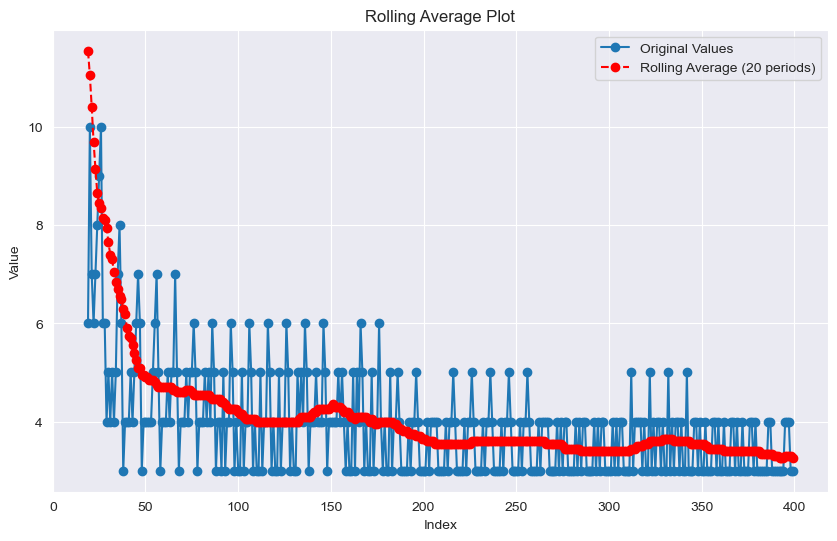

3.34
0.4737087712930805
its:  400
3.45
0.57227615711298
Gibb sampling on sample index:  0 outer it:  40
it:  0  || Likelihood:  -21272.580363804693  || n_components:  3
Gibb sampling on sample index:  1 outer it:  40
it:  0  || Likelihood:  -21574.46501049807  || n_components:  3
Gibb sampling on sample index:  2 outer it:  40
it:  0  || Likelihood:  -21542.120607048895  || n_components:  3
Gibb sampling on sample index:  3 outer it:  40
it:  0  || Likelihood:  -21296.087882518263  || n_components:  3
Gibb sampling on sample index:  4 outer it:  40
it:  0  || Likelihood:  -21413.42475973101  || n_components:  3
Gibb sampling on sample index:  5 outer it:  40
it:  0  || Likelihood:  -21353.79903304461  || n_components:  3
Gibb sampling on sample index:  6 outer it:  40
it:  0  || Likelihood:  -21218.521786289857  || n_components:  4
Gibb sampling on sample index:  7 outer it:  40
it:  0  || Likelihood:  -21342.337600962284  || n_components:  4
Gibb sampling on sample index:  8 outer it:

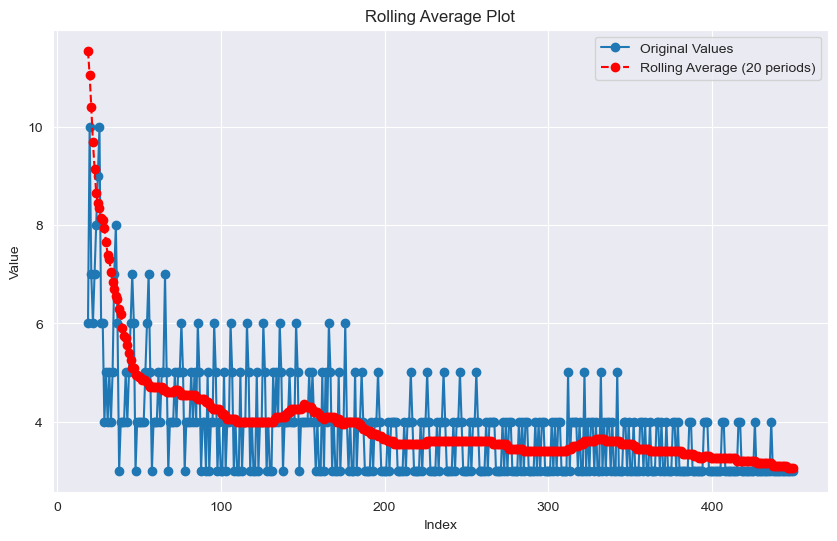

3.12
0.32496153618543844
its:  450
3.23
0.4208325082500164
Gibb sampling on sample index:  0 outer it:  45
it:  0  || Likelihood:  -21242.944328897007  || n_components:  3
Gibb sampling on sample index:  1 outer it:  45
it:  0  || Likelihood:  -21582.330642381494  || n_components:  3
Gibb sampling on sample index:  2 outer it:  45
it:  0  || Likelihood:  -21538.003202587017  || n_components:  3
Gibb sampling on sample index:  3 outer it:  45
it:  0  || Likelihood:  -21309.767044370325  || n_components:  3
Gibb sampling on sample index:  4 outer it:  45
it:  0  || Likelihood:  -21402.14804996885  || n_components:  3
Gibb sampling on sample index:  5 outer it:  45
it:  0  || Likelihood:  -21340.15414892061  || n_components:  3
Gibb sampling on sample index:  6 outer it:  45
it:  0  || Likelihood:  -21269.823068251146  || n_components:  3
Gibb sampling on sample index:  7 outer it:  45
it:  0  || Likelihood:  -21369.181523144154  || n_components:  3
Gibb sampling on sample index:  8 outer

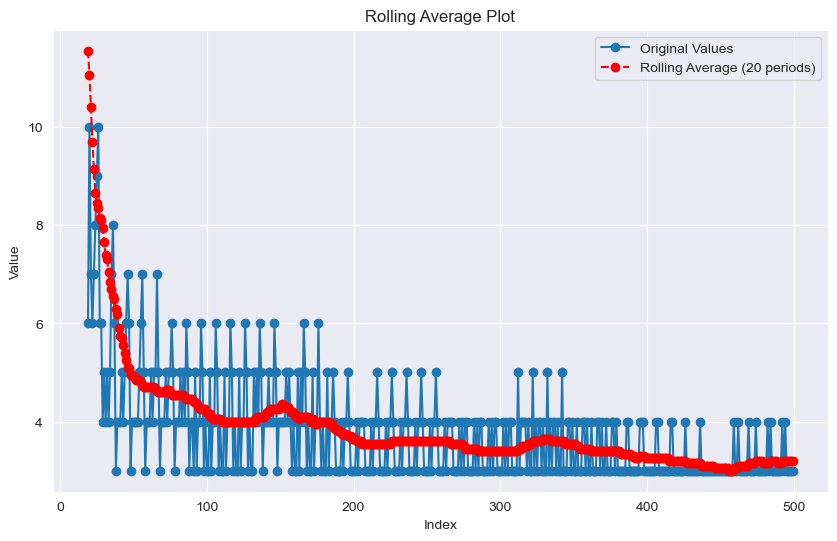

3.16
0.36660605559646725
its:  500
3.14
0.3469870314579495
Gibb sampling on sample index:  0 outer it:  50
it:  0  || Likelihood:  -21266.100136717505  || n_components:  3
Gibb sampling on sample index:  1 outer it:  50
it:  0  || Likelihood:  -21578.64807378253  || n_components:  3
Gibb sampling on sample index:  2 outer it:  50
it:  0  || Likelihood:  -21497.235819360183  || n_components:  4
Gibb sampling on sample index:  3 outer it:  50
it:  0  || Likelihood:  -21311.18612865972  || n_components:  3
Gibb sampling on sample index:  4 outer it:  50
it:  0  || Likelihood:  -21369.013407579405  || n_components:  4
Gibb sampling on sample index:  5 outer it:  50
it:  0  || Likelihood:  -21354.173409008712  || n_components:  3
Gibb sampling on sample index:  6 outer it:  50
it:  0  || Likelihood:  -21263.50391856754  || n_components:  3
Gibb sampling on sample index:  7 outer it:  50
it:  0  || Likelihood:  -21352.928771135692  || n_components:  3
Gibb sampling on sample index:  8 outer 

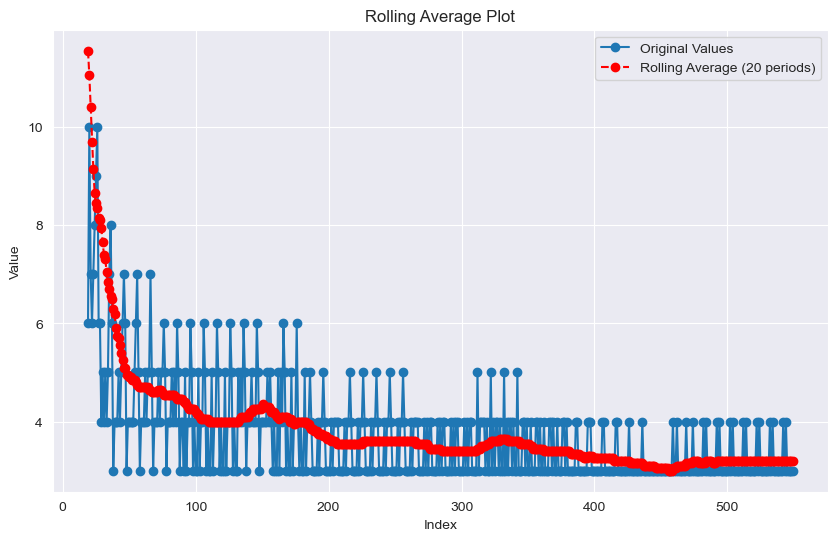

3.2
0.39999999999999997
its:  550
3.18
0.38418745424597095
Gibb sampling on sample index:  0 outer it:  55
it:  0  || Likelihood:  -21249.833868204998  || n_components:  3
Gibb sampling on sample index:  1 outer it:  55
it:  0  || Likelihood:  -21596.258269349946  || n_components:  3
Gibb sampling on sample index:  2 outer it:  55
it:  0  || Likelihood:  -21511.618747347133  || n_components:  4
Gibb sampling on sample index:  3 outer it:  55
it:  0  || Likelihood:  -21308.073789134545  || n_components:  3
Gibb sampling on sample index:  4 outer it:  55
it:  0  || Likelihood:  -21404.698377455785  || n_components:  4
Gibb sampling on sample index:  5 outer it:  55
it:  0  || Likelihood:  -21331.01622207278  || n_components:  3
Gibb sampling on sample index:  6 outer it:  55
it:  0  || Likelihood:  -21275.078153604303  || n_components:  3
Gibb sampling on sample index:  7 outer it:  55
it:  0  || Likelihood:  -21353.26754224094  || n_components:  3
Gibb sampling on sample index:  8 outer

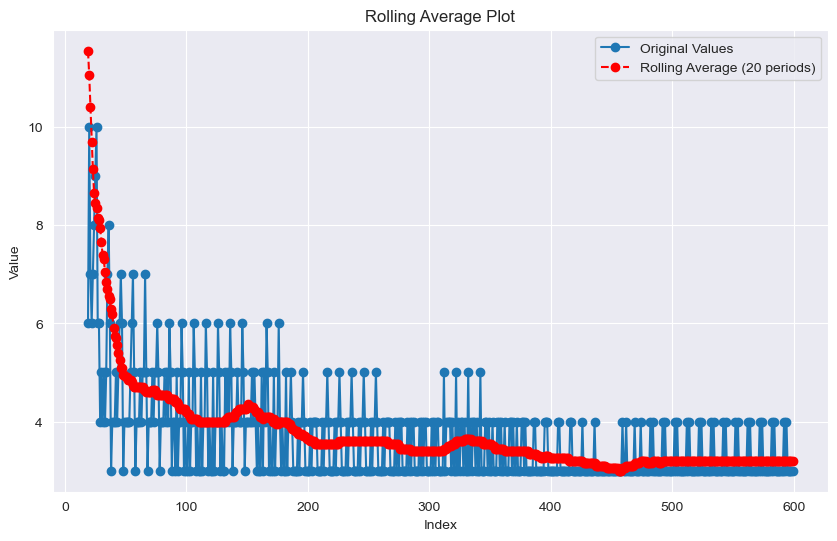

3.2
0.39999999999999997
its:  600
3.2
0.4
conditions met gibbs sampling complete
completed gibbs sampling in  51.23378801345825


In [142]:
trained_noise_hmm = noise_ihmm.fit_multiple(iterations=1,outer_its=100,burn_in=0,verbose=True, simple_verbose=True, new_list=concatenated_list, return_hmm=True)

In [39]:
# noise_ihmm.plot_components_trace()
# test_hmm_i = noise_ihmm.hmm_from_trace(4,100)

In [ ]:
# noise_hmm = GaussianHMM(3, covariance_type='full', init_params='')
# noise_hmm.fit(np.concatenate(test_noise_features))
# noise_hmm.

In [143]:

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], trained_noise_hmm)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])


In [144]:
# test dc

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(test_new.features))
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels), val_pred_fhmm)
print(accuracy)

{'ACC': 0.5742126326779189, 'PPV': 0.5338745800671892, 'TPR': 0.70918557084418, 'TNR': 0.45552648790058864, 'FPR': 0.5444735120994114, 'FNR': 0.29081442915582}


In [61]:
plt.plot(np.concatenate(test_new.feature_labels), c='black')
plt.plot(useful.smooth_labels(val_pred_fhmm), '--', c='red')

NameError: name 'test_new' is not defined

gibbs sampling start
iterations per sample:  1
Gibb sampling on sample index:  0 outer it:  0
it:  0  || Likelihood:  -23787.041943231332  || n_components:  3
Gibb sampling on sample index:  0 outer it:  1
it:  0  || Likelihood:  -23545.477862564723  || n_components:  3
Gibb sampling on sample index:  0 outer it:  2
it:  0  || Likelihood:  -23452.881356353806  || n_components:  3
Gibb sampling on sample index:  0 outer it:  3
it:  0  || Likelihood:  -23395.629395706026  || n_components:  3
Gibb sampling on sample index:  0 outer it:  4
it:  0  || Likelihood:  -23433.208976340255  || n_components:  3
Gibb sampling on sample index:  0 outer it:  5
it:  0  || Likelihood:  -23376.757608928256  || n_components:  3
Gibb sampling on sample index:  0 outer it:  6
it:  0  || Likelihood:  -23432.291829914302  || n_components:  3
Gibb sampling on sample index:  0 outer it:  7
it:  0  || Likelihood:  -23372.494519946053  || n_components:  3
Gibb sampling on sample index:  0 outer it:  8
it:  0  ||

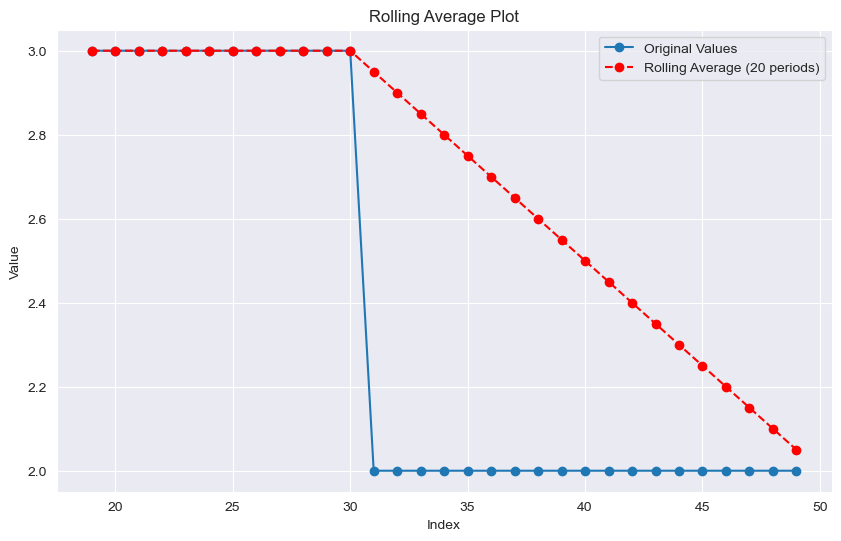

2.62
0.4853864439804638
Gibb sampling on sample index:  0 outer it:  50
it:  0  || Likelihood:  -23399.725323772327  || n_components:  2
Gibb sampling on sample index:  0 outer it:  51
it:  0  || Likelihood:  -23375.181879314918  || n_components:  2
Gibb sampling on sample index:  0 outer it:  52
it:  0  || Likelihood:  -23395.349403838325  || n_components:  2
Gibb sampling on sample index:  0 outer it:  53
it:  0  || Likelihood:  -23363.083487189157  || n_components:  2
Gibb sampling on sample index:  0 outer it:  54
it:  0  || Likelihood:  -23359.142737197093  || n_components:  2
Gibb sampling on sample index:  0 outer it:  55
it:  0  || Likelihood:  -23386.987400154747  || n_components:  2
Gibb sampling on sample index:  0 outer it:  56
it:  0  || Likelihood:  -23364.380395979453  || n_components:  2
Gibb sampling on sample index:  0 outer it:  57
it:  0  || Likelihood:  -23400.94716766893  || n_components:  2
Gibb sampling on sample index:  0 outer it:  58
it:  0  || Likelihood:  -

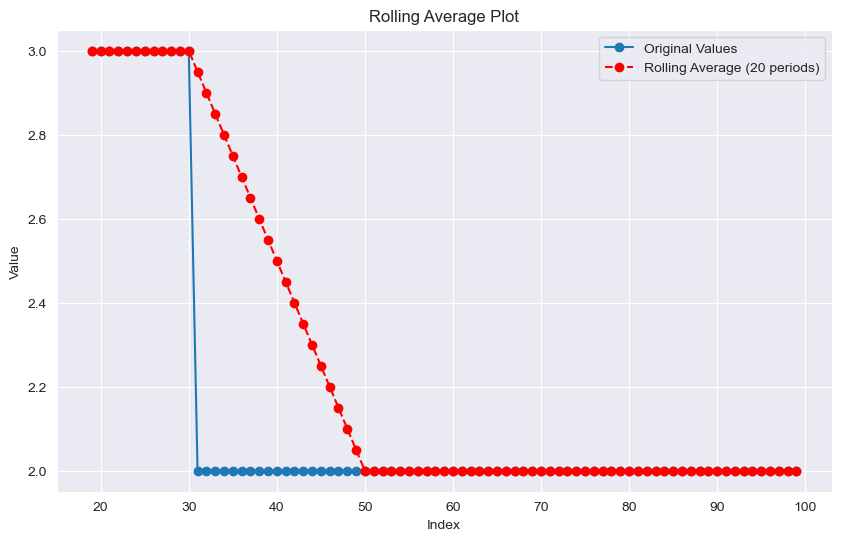

2.0
0.0
completed gibbs sampling in  11.761538982391357
gibbs sampling end


KeyboardInterrupt: 

In [146]:
# insert for adaptive noise handling
# update noise hmm to bayesian / HDP ?

class NoiseAdaptiveHMM:
    def __init__(self, dc_model: dc.DecodeCombineGaussian, signal_hmms, n_hmm: GaussianHMM, ihmm: hdphmmwl.HDPHMMWL):
        self.dc_model: dc.DecodeCombineGaussian = dc_model
        self.signal_hmms = signal_hmms  # dict with hmms inside
        self.n_hmm = n_hmm
        self.ihmm = ihmm

    def update_model(self, new_noise_features):

        # concat new_noise_features, not sure if input features will be long enough...
        # concatenated_new_noise_features = [
        # np.concatenate(random.sample(test_noise_features, 8))
        # for _ in range(10)
        # ]

        # new noise features, aim is to update fhmms and then dc_model
        print('gibbs sampling start')
        new_noise_hmm = self.ihmm.fit_multiple(iterations=1,outer_its=100,burn_in=0,verbose=True, simple_verbose=True, new_list=[new_noise_features], return_hmm=True)
        print('gibbs sampling end')
        # reverse fhmm update means
        new_noise_hmm.means_ = useful.reverse_fhmm(new_noise_hmm, self.signal_hmms[NOISE])
        self.n_hmm = new_noise_hmm

        # self.n_hmm.fit(new_noise_features)
        updated_fhmms = {}
        for key in self.signal_hmms:
            updated_fhmm = FactorialHMM(hmms[key], new_noise_hmm)
            updated_fhmms[key] = updated_fhmm.hmm

        self.dc_model = dc.DecodeCombineGaussian([u_fhmm for u_fhmm in updated_fhmms.values()])

        print('model updated to changing noise conditions')


def sliding_windows(data, window_size, step_size, na_hmm: NoiseAdaptiveHMM, mean_log_prob, threshold = 1.2, re_train_buffer=10):
    output = {
        'noise_data': []
    }
    windows = []
    log_probs = []
    std_probs = []
    states_decoded = np.zeros(len(data))
    window_indices = []

    train_counter = 0
    last_close = None

    large_avg = 30
    small_avg = 10


    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i+window_size, :]

        # do stuff here
        _, test_pred, log_prob = na_hmm.dc_model.decode_hmmlearn(window)

        log_probs.append(log_prob)
        states_decoded[i:i+window_size] = test_pred
        windows.append(window)
        window_indices.append(i)
        std_probs.append(np.std(log_probs[-3:]))

        # avoid re-training a lot
        if train_counter > 0:
            train_counter -= 1

        # if rolling average long and rolling average short are close then record likelihood

        if len(windows) > 50:
            if last_close is None:
                last_close = np.abs(np.mean(log_probs[-large_avg:]))
            avg_small = np.abs(np.mean(log_probs[-small_avg:]))
            avg_large = np.abs(np.mean(log_probs[-large_avg:]))
            # if np.abs(avg_small - avg_large) < 100:
            #     if np.abs(avg_large - last_close) > 450:
            #         print(np.abs(np.abs(np.mean(log_probs[-small_avg:])) - np.abs(last_close)))
            #         print('yay')
            #     last_close = np.abs(log_prob)


            # if likelihood drops bellow threshold then re-train noise hmm and update other hmms
            if avg_large > 25000 and train_counter == 0:
                # use last 3 windows to train noise hmm
                # data[i:i + (step_size * 3)]
                start_index = window_indices[-3]
                noise_data = data[start_index:start_index + (step_size * 10)]   # into future update for real time
                na_hmm.update_model(noise_data)

                output['noise_data'].append(noise_data)

                # start buffer to avoid a lot of re-training
                train_counter = re_train_buffer

    output['windows'] = np.array(windows)
    output['prob'] = log_probs
    output['states'] = states_decoded
    return output

# Define sliding window parameters
window_size = 200
step_size = 50
my_noise_adapt_hmm = NoiseAdaptiveHMM(combined_model, hmms, trained_noise_hmm, noise_ihmm)
out = sliding_windows(test_features_concat, window_size, step_size, my_noise_adapt_hmm, -50000, 1.2)
windows_states = out['states']

In [51]:
useful.vis_helper(out['noise_data'][0])

IndexError: list index out of range

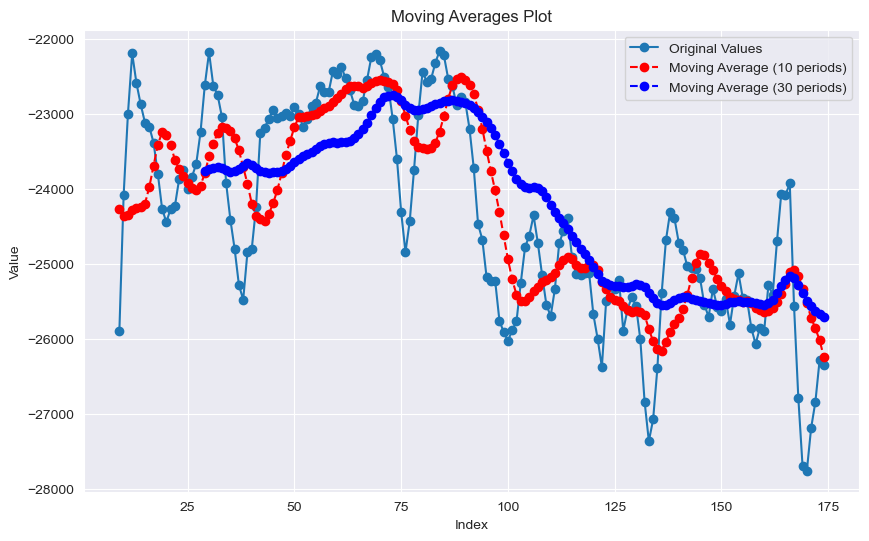

In [116]:
# close_test = np.isclose(windows_states, test_pred[:len(windows_states)])
my_data = out['prob']

# Define the window sizes for the moving averages
window_size1 = 10
window_size2 = 30

# Create kernels for the moving averages
kernel1 = np.ones(window_size1) / window_size1
kernel2 = np.ones(window_size2) / window_size2

# Use np.convolve to calculate the moving averages
moving_avg1 = np.convolve(my_data, kernel1, mode='valid')
moving_avg2 = np.convolve(my_data, kernel2, mode='valid')

# Create an array of indices corresponding to the original data for plotting
indices1 = np.arange(window_size1 - 1, len(my_data))
indices2 = np.arange(window_size2 - 1, len(my_data))

# Plot the data and moving averages
plt.figure(figsize=(10, 6))
plt.plot(indices1, my_data[window_size1 - 1:], label='Original Values', marker='o')
plt.plot(indices1, moving_avg1, label=f'Moving Average ({window_size1} periods)',
         color='red', linestyle='--', marker='o')
plt.plot(indices2, moving_avg2, label=f'Moving Average ({window_size2} periods)',
         color='blue', linestyle='--', marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Moving Averages Plot')
plt.legend()
plt.show()

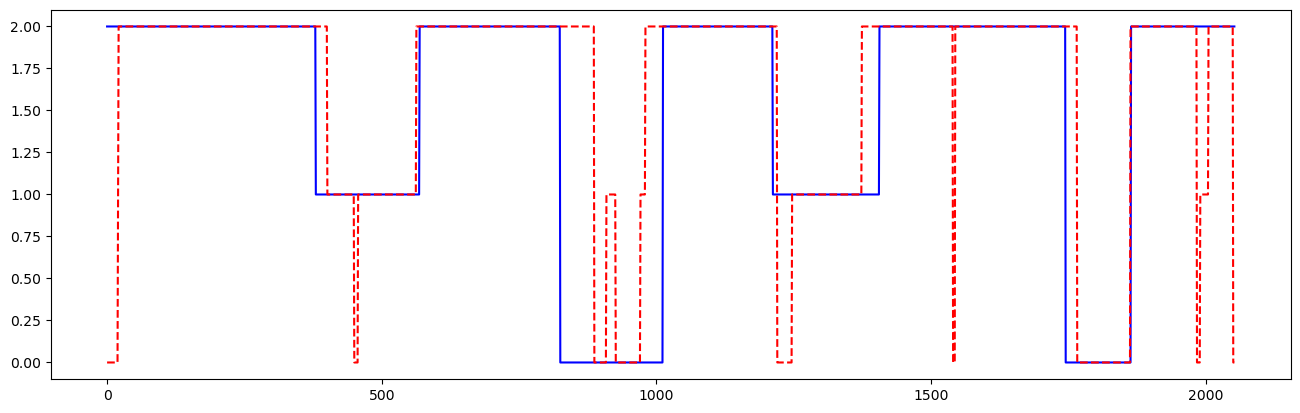

In [117]:
plt.plot(np.concatenate(test_new.feature_labels)[3000:], c='b')
plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='r')
# plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='g')

In [119]:
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels)[3000:], useful.smooth_labels(windows_states[3000:]))
print(accuracy)

{'acc': 0.8036036036036036, 'tpr': 0.8080229226361032, 'fpr': 0.20388349514563106}


In [34]:

smoothed_labels = useful.smooth_labels(test_pred_subset)
# print("Original Labels:", labels)
# print("Smoothed Labels:", smooth_labels(labels))

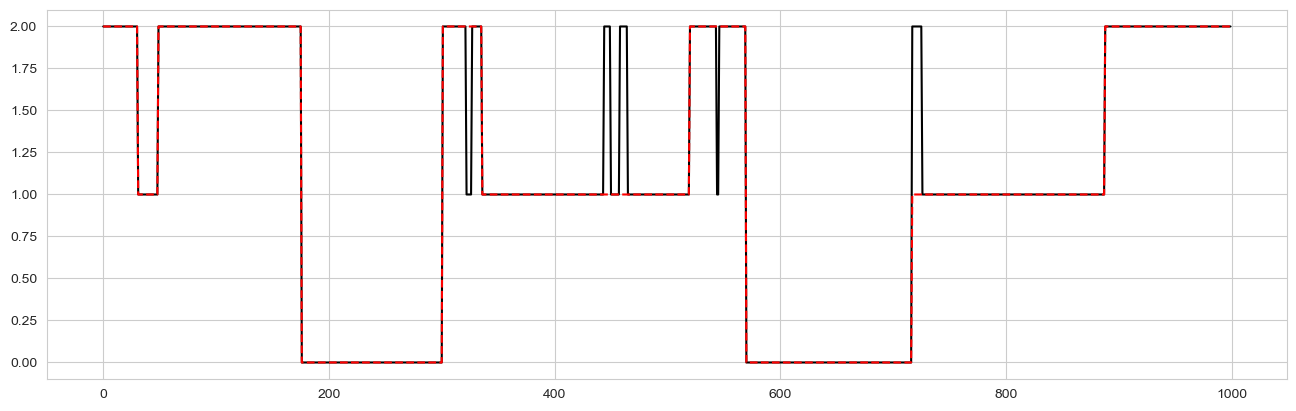

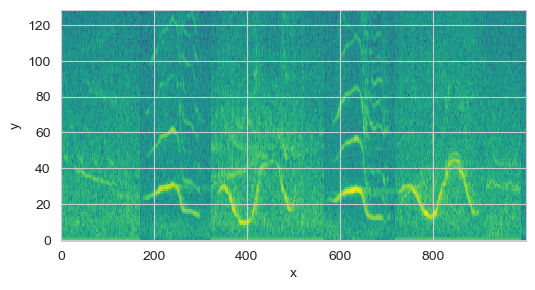

In [35]:
import matplotlib.pyplot as plt
plt.plot(test_pred_subset, c='black')
plt.plot(smoothed_labels, '--', c='red')
useful.vis_helper(test_features_concat_subset)

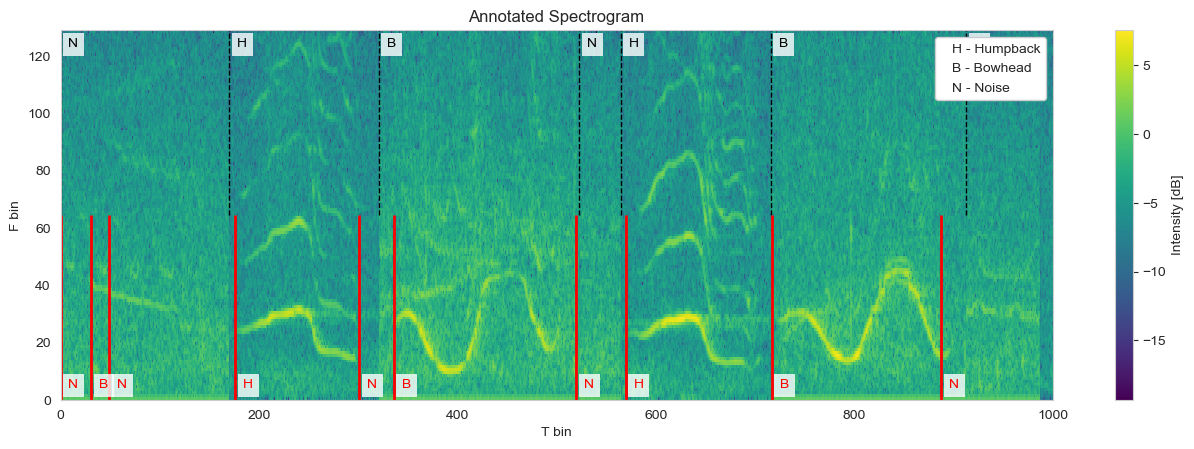

In [36]:
# plot spectrogram showing models and given annots,
importlib.reload(useful)

label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(test_features_concat_subset, np.concatenate(test.feature_labels)[:1000], smoothed_labels, label_to_type, label_to_abr)